<h1 style="text-align: center;">Data Visualization Project</h1>
<h2 style="text-align: center;">Dogs vs. Cats Dataset</h2>

# Preface
* Dogs vs. Cats is a dataset containing 25,000 samples. Each sample is a colored image (JPEG file) of a dog or a cat.
* The data contains two labels (mentioned in each file name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore, also known as offline/batch learning.
* ***Main objective:*** Find the best algorithm and model parameters that classify the unseen images correctly.

In [114]:
# common imports
import numpy as np
import pandas as pd
import os, cv2, joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.dummy import DummyClassifier
from sklearn import clone
from xgboost import XGBClassifier, cv, DMatrix

# global variables
path = r"dogs-vs-cats\train/"
global ROWS, COLUMNS, CHANNELS, IS_CANNY
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
plt.style.use('seaborn')  # for plots

# 1. Getting the Data

In [115]:
# function loads a DataFrame with the path and label of the images
def load_dogs_vs_cats(image_dir):
    # listdir returns a list with the file names in the given directory
    images_lst = [image_dir + i for i in os.listdir(image_dir)]
    y = []
    path = []
    # enumerate() function iterates the input object by using two variables:
    # i is the count of the current iteration
    # image_path is the path of the image file at the current iteration
    for i, image_path in enumerate(images_lst):
        path.append(image_path)
        if '/dog' in image_path:
            y.append(1)
        elif '/cat' in image_path:
            y.append(0)
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y.append(image_path.split('/')[-1].split('.')[0])
    return pd.DataFrame({"path": path, "label": y})

In [116]:
# use function to load data
df = load_dogs_vs_cats(path)

In [117]:
# display the first 5 rows for a quick look
df.head()

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0
3,dogs-vs-cats\train/cat.100.jpg,0
4,dogs-vs-cats\train/cat.1000.jpg,0


In [118]:
# DataFrame shape (rows, columns)
df.shape

(25000, 2)

In [119]:
# check for missing values
df.isna().sum().sum()

0

In [120]:
# number of instances for each category
df['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [121]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [122]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3]
sample0

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0


In [123]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3]
sample1

,path,label
12500,dogs-vs-cats\train/dog.0.jpg,1
12501,dogs-vs-cats\train/dog.1.jpg,1
12502,dogs-vs-cats\train/dog.10.jpg,1


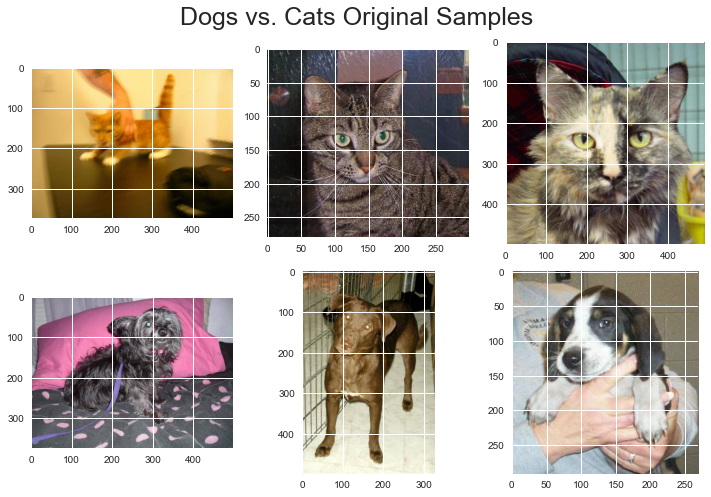

In [124]:
# combine cat and dog samples as one DataFrame
sample_images = pd.concat([sample0, sample1], ignore_index=True)

# plot image samples
fig = plt.figure(figsize=(10, 7))
for i in range(len(sample_images)):
    plt.subplot(230 + i + 1) # 2 rows, 3 cols, i + 1 for image placement
    filename = sample_images['path'][i]
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # convert color format (cv2 uses BGR and matplotlib uses RGB)
fig.suptitle("Dogs vs. Cats Original Samples", size=25)
plt.tight_layout()
plt.show()

> #### Initial Observations:
* Each label has an equal amount of samples, making this a **balanced classification** task.
* By looking at the indices of the sample images, it looks like the first 12,500 images are only cats
and the remaining are dogs. Certain algorithms are sensitive to the order of the data, so
the images should be shuffled.
* Some images are cropped in a way that only the face is seen, others of the whole body.
* The photos may also include a person or surrounding objects (i.e. in the bottom right image the
dog is held by a person). The photos could also be blurry (i.e. in the top left photo it looks
like the camera was slightly moved while taking the photo).

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

> The training and testing data should be representative of both classes.
I noticed that the number of samples for each label are equal and decided a **stratified
split** is the optimal choice.
Although regular random sampling would have split the data nearly equally, there would
have been more bias towards one of the classes.
>> Note: As recommended earlier, StratifiedShuffleSplit also shuffles the data.

In [125]:
# provides the indices to split the data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['label']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [126]:
# make sure that class distribution is equal
strat_test_set['label'].value_counts() / len(strat_test_set)

1    0.5
0    0.5
Name: label, dtype: float64

In [127]:
# DataFrame shape (rows, columns)
print("Training Set:", strat_train_set.shape)
print("Test Set:", strat_test_set.shape)

Training Set: (20000, 2)
Test Set: (5000, 2)


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [128]:
# deep copy of the training set
df2 = strat_train_set.copy()

In [129]:
df2.head(2)

,path,label
20022,dogs-vs-cats\train/dog.5518.jpg,1
4993,dogs-vs-cats\train/cat.3241.jpg,0


In [130]:
# function returns shape of loaded image from the provided path
def image_shape(image_path):
    return cv2.imread(image_path).shape

# function returns DataFrame containing image shapes
def load_data_shapes(image_file_names):
    shapes = []
    for i, image_file in enumerate(image_file_names):
        shapes.append(image_shape(image_file))
    return pd.DataFrame(shapes, columns=['height', 'width', 'n_channels'])

In [131]:
# use function to get list with image shapes
# image_shapes = load_data_shapes(strat_train_set['path'])
# joblib.dump(image_shapes, "dogs-vs-cats/image_shapes.pkl")
image_shapes = joblib.load(r"dogs-vs-cats/image_shapes.pkl")
image_shapes.head(3)

,height,width,n_channels
0,138,129,3
1,374,500,3
2,438,349,3


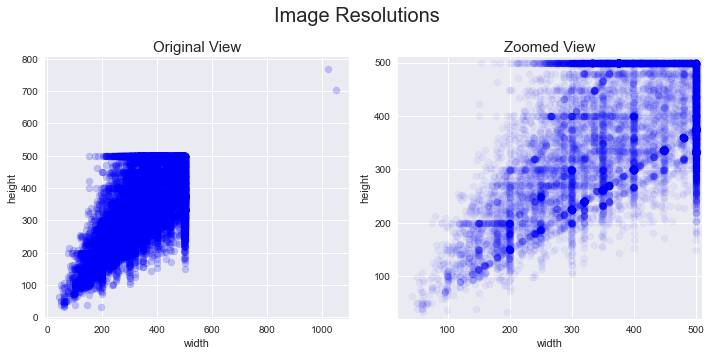

In [132]:
# plot image resolutions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(image_shapes.width, image_shapes.height, color='blue', alpha=0.2)
ax1.set_title("Original View", size=15)
points = ax2.scatter(image_shapes.width, image_shapes.height, color='blue', alpha=0.05)
ax1.set_xlabel("width")
ax1.set_ylabel("height")
ax2.set_xlim(xmin=20, xmax=510)
ax2.set_ylim(ymin=20, ymax=510)
ax2.set_title("Zoomed View", size=15)
ax2.set_xlabel("width")
ax2.set_ylabel("height")
fig.suptitle("Image Resolutions", size=20)
plt.tight_layout()
plt.show()

In [133]:
# minimum height
image_shapes["height"].min()

32

In [134]:
# minimum width
image_shapes["width"].min()

42

In [135]:
# check the number of channels
image_shapes.n_channels.unique()

array([3], dtype=int64)

> Observations:
* Most image resolutions are 500x500 or less. There is also a fair amount around 400x400,
300x300, and 200x200.
* The images are in color, meaning the number of pixels chosen for the width and height will be multiplied by 3.
This should be taken into account since it adds a substantial amount of features, as opposed to using one channel
(i.e. grayscale).

# 3. Pre-Processing the Data

## Choosing Pre-processing Implementations
> In this next part, I will evaluate several pre-processing options.
>
>> Important Notes:
* In order to use the data for ML algorithms, all images need to be processed into the <u>same size</u>.
* The pixels represent the features in the data. <u>The larger the size, the higher the complexity</u>.
* Increasing small images can stretch the pixels, so it could be better to stay in the range of the
<u>smaller image ratios</u> and downsize the larger images.
* Training a baseline model on the various sizes and transformations can be used as an evaluation measure
to help determine the best pre-processing implementation.
>
> #### Choosing the Right Size With <u>Progressive Resizing</u>:
> In this approach, the images are rescaled starting from a small size and gradually increasing them.
>> Note: Since the minimum height of the images is 32 and minimum width is 42, starting from 30x30 seems fitting.
> #### Image Transformation Options:
> I will try each size on 3 different transformations (in order from highest to lowest complexity):
>> Transformations:
1. Color
2. Grayscale
3. Canny Edge Detection
>>> #### What is Canny Edge Detection?
> This multi-stage algorithm (developed by John F. Canny) identifies the edges in images.
> This provides a simple way to pre-process the images and detect objects in them.
> The resulting image is a binary one, which overall simplifies the data and can reduce computational time.
>>>> Note: The algorithm is based on grayscale images.

#### The following functions read the data:

In [136]:
# set global variables
def set_params(n_rows, n_cols, n_channels, is_canny):
    global ROWS, COLUMNS, CHANNELS, IS_CANNY
    ROWS = n_rows
    COLUMNS = n_cols
    CHANNELS = n_channels
    IS_CANNY = is_canny


# function loads images according to the global variables set
# cubic interpolation results in high quality images when shrinking images
def read_resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if CHANNELS == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image from BGR to RGB
    elif CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert image to grayscale
        if IS_CANNY:
            img = cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)
            img = cv2.Canny(img, 100, 200) # cv2 canny recommended threshold (upper:lower ratio) between 2:1 and 3:1
            return img
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)


# function returns the data as a matrix containing the pixel values and y array with the corresponding labels
# input parameters are provided for setting the chosen ratio and transformations
def prep_data(images, n_rows, n_cols, n_channels, is_canny):
    set_params(n_rows, n_cols, n_channels, is_canny) # set global variables with inserted values
    m = len(images) # number of instances
    n_pixels = ROWS * COLUMNS * CHANNELS # number of features
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1), dtype=np.uint8)

    # enumerate() function iterates the input object ('images') by using two variables:
    # i is the count of the current iteration
    # img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y.flatten() # flatten returns copy of the vector column as a row

> ### Feature Scaling
>
> Although the pixel values are in a known range [0,255], scaling the data can make a crucial difference
> (especially if the learning algorithm relies on calculating distances).
>
> Chosen feature scale:
>
> Standardizing centers the data so that it has a zero mean and a standard deviation of 1, under the assumption
> that the data is normally distributed.
> Furthermore, dimensionality reduction should be useful later on since the data will contain a large
> amount of features (i.e. PCA is assumes the data has zero mean).
>
> Therefore, standard scaling is the ideal option.

In [137]:
# create transformation pipeline
full_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

In [138]:
# original sample images
img1_before = strat_train_set['path'][0:1].iloc[0]
img2_before = strat_train_set['path'][1:2].iloc[0]

# function plots sample images next to transformed samples
def plot_before_after(img1, img2):
    # define figure and number of subplots
    fig, ax = plt.subplots(1, 4, figsize=(14,4))
    # plot first image before
    image = cv2.imread(img1_before)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[0].imshow(image)
    ax[0].grid(False)
    ax[0].set_title("Before", size=15)
    # plot first image after
    image = img1.reshape((ROWS, COLUMNS, CHANNELS))
    ax[1].imshow(image, cmap='gray')
    ax[1].grid(False)
    ax[1].set_title("After", size=15)
    # plot second image before
    image = cv2.imread(img2_before)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[2].imshow(image)
    ax[2].grid(False)
    ax[2].set_title("Before", size=15)
    # plot second image after
    image = img2.reshape((ROWS, COLUMNS, CHANNELS))
    ax[3].imshow(image, cmap='gray')
    ax[3].grid(False)
    ax[3].set_title("After", size=15)

    fig.suptitle("Resize Samples", size=20)
    plt.tight_layout()
    plt.show()

> As previously mentioned, the number of instances for each class in the training set are equal.
>
> Chosen evaluation metric:
>
> Accuracy works well with balanced classification tasks.
> It is also the most intuitive metric and simplest to understand.
>> Note:
* Accuracy is sensitive to the test size. Therefore, I will use 4 cross-validation folds
(total of 5,000 instances in each test fold).
* Since the features consist of pixel values (a fixed range), it is likely that the testing data would fit the
transformers nearly the same. This means that cross-validation should give good assessment
of the performance on unseen data, even when evaluating only from the fitted and transformed training data.

In [139]:
# function for evaluating cross validation scores and for easy model comparison
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 5))
    print("Standard Deviation:", round(scores.std(), 5))

> #### That was a lot of information! Here's a quick recap:
1. Start rescaling from 30x30 and gradually increase.
2. Train Logistic Regression baseline models on various the data transformations.
3. Evaluate the accuracy score.
4. Repeat the previous steps a few times.
5. Choose the optimal scale and colors.

## Pixels: 30x30

> ### 30x30x3 Color

Data shape: (20000, 2700)
Target shape: (20000,)


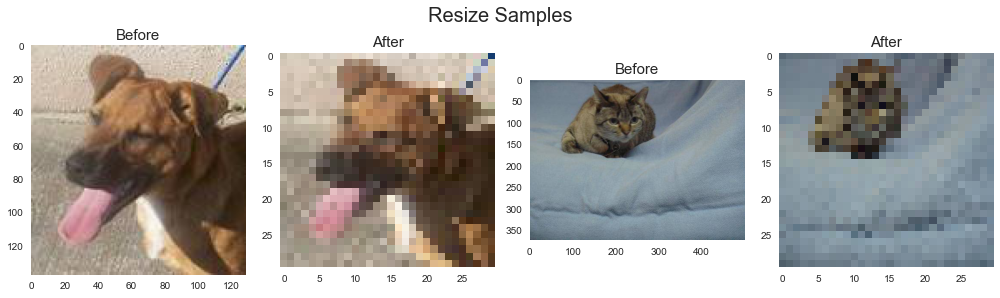

In [90]:
# X_30, y_30 = prep_data(strat_train_set["path"], 30, 30, 3, is_canny=False)
# joblib.dump(X_30, "dogs-vs-cats/data/X_30.pkl")
# joblib.dump(y_30, "dogs-vs-cats/data/y_30.pkl")

X_30 = joblib.load(r"dogs-vs-cats/data/X_30.pkl")
y_30 = joblib.load(r"dogs-vs-cats/data/y_30.pkl")
set_params(30, 30, 3, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_30.shape)
print("Target shape:", y_30.shape)

plot_before_after(X_30[0], X_30[1])

# X_30 = StandardScaler().fit_transform(X_30)

In [91]:
# log_reg_30 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30.fit(X_30, y_30)
# joblib.dump(log_reg_30, "dogs-vs-cats/models/log_reg_30.pkl")
log_reg_30 = joblib.load(r"dogs-vs-cats/models/log_reg_30.pkl")

In [92]:
# log_reg_30_pred = log_reg_30.predict(X_30)
# joblib.dump(log_reg_30_pred, "dogs-vs-cats/pred/log_reg_30_pred.pkl")
log_reg_30_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30_pred.pkl")
metrics.accuracy_score(y_30, log_reg_30_pred)

0.68855

In [93]:
# log_reg_30_scores = cross_val_score(log_reg_30, X_30, y_30, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30_scores, "dogs-vs-cats/scores/log_reg_30_scores.pkl")
log_reg_30_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30_scores.pkl")
display_scores(log_reg_30_scores)

Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


> ### 30x30 Grayscale

Data shape: (20000, 900)
Target shape: (20000,)


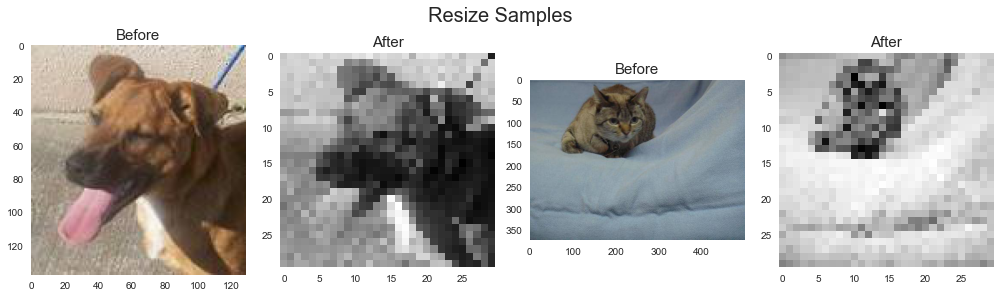

In [94]:
# X_30g, y_30g = prep_data(strat_train_set["path"], 30, 30, 1, is_canny=False)
# joblib.dump(X_30g, "dogs-vs-cats/data/X_30g.pkl")
# joblib.dump(y_30g, "dogs-vs-cats/data/y_30g.pkl")

X_30g = joblib.load(r"dogs-vs-cats/data/X_30g.pkl")
y_30g = joblib.load(r"dogs-vs-cats/data/y_30g.pkl")
set_params(30, 30, 1, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_30g.shape)
print("Target shape:", y_30g.shape)

plot_before_after(X_30g[0], X_30g[1])
X_gray= X_30g.copy()
y_gray=y_30g.copy()
X_30g = StandardScaler().fit_transform(X_30g)

In [95]:
# log_reg_30g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30g.fit(X_30g, y_30g)
# joblib.dump(log_reg_30g, "dogs-vs-cats/models/log_reg_30g.pkl")
log_reg_30g = joblib.load(r"dogs-vs-cats/models/log_reg_30g.pkl")

In [96]:
# log_reg_30g_pred = log_reg_30g.predict(X_30g)
# joblib.dump(log_reg_30g_pred, "dogs-vs-cats/pred/log_reg_30g_pred.pkl")
log_reg_30g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30g_pred.pkl")
metrics.accuracy_score(y_30g, log_reg_30g_pred)

0.6097

In [97]:
# log_reg_30g_scores = cross_val_score(log_reg_30g, X_30g, y_30g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30g_scores, "dogs-vs-cats/scores/log_reg_30g_scores.pkl")
log_reg_30g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30g_scores.pkl")
display_scores(log_reg_30g_scores)

Scores: [0.5456 0.5286 0.5462 0.551 ]
Mean: 0.54285
Standard Deviation: 0.00849


> ### 30x30 Canny

Data shape: (20000, 900)
Target shape: (20000,)


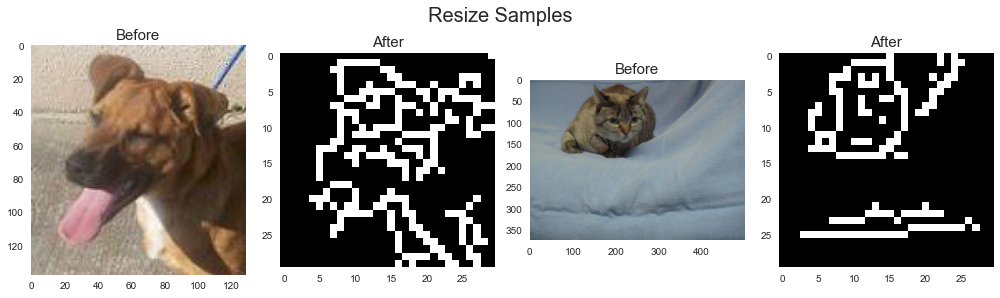

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37  38  39   40   41   42   43   44   45   46  47   48  49  50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82  83   84   85   86   87   88   89   90   91   92   93  94   95   96   97   98   99   100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  20

In [108]:
# X_30C, y_30C = prep_data(strat_train_set["path"], 30, 30, 1, is_canny=True)
# joblib.dump(X_30C, "dogs-vs-cats/data/X_30C.pkl")
# joblib.dump(y_30C, "dogs-vs-cats/data/y_30C.pkl")

X_30C = joblib.load(r"dogs-vs-cats/data/X_30C.pkl")
y_30C = joblib.load(r"dogs-vs-cats/data/y_30C.pkl")
set_params(30, 30, 1, is_canny=True)

# data shape (rows, columns)
print("Data shape:", X_30C.shape)
print("Target shape:", y_30C.shape)

plot_before_after(X_30C[0], X_30C[1])
X_canny = X_30C.copy()
y_canny = y_30C.copy()
#X_30C = StandardScaler().fit_transform(X_30C)

pd.DataFrame(X_canny).value_counts()

In [99]:
# log_reg_30C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30C.fit(X_30C, y_30C)
# joblib.dump(log_reg_30C, "dogs-vs-cats/models/log_reg_30C.pkl")
log_reg_30C = joblib.load(r"dogs-vs-cats/models/log_reg_30C.pkl")

In [66]:
# log_reg_30C_pred = log_reg_30C.predict(X_30C)
# joblib.dump(log_reg_30C_pred, "dogs-vs-cats/pred/log_reg_30C_pred.pkl")
log_reg_30C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30C_pred.pkl")
metrics.accuracy_score(y_30C, log_reg_30C_pred)

0.65105

In [67]:
# log_reg_30C_scores = cross_val_score(log_reg_30C, X_30C, y_30C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30C_scores, "dogs-vs-cats/scores/log_reg_30C_scores.pkl")
log_reg_30C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30C_scores.pkl")
display_scores(log_reg_30C_scores)

Scores: [0.5924 0.595  0.5964 0.5816]
Mean: 0.59135
Standard Deviation: 0.00581


## Pixels: 40x40

> ### 40x40x3 Color

Data shape: (20000, 4800)
Target shape: (20000,)


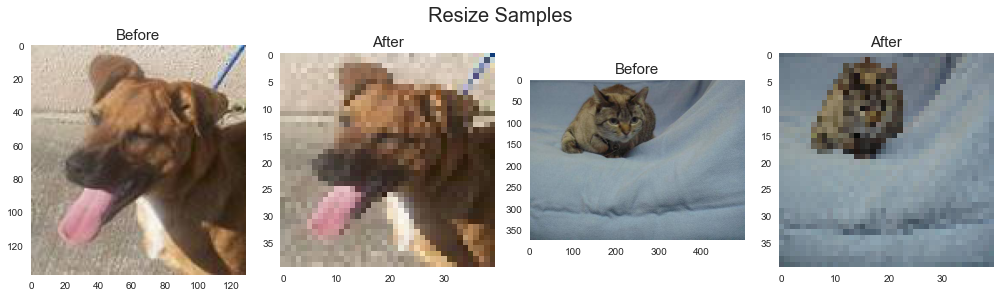

In [68]:
# X_40, y_40 = prep_data(strat_train_set["path"], 40, 40, 3, is_canny=False)
# joblib.dump(X_40, "dogs-vs-cats/data/X_40.pkl")
# joblib.dump(y_40, "dogs-vs-cats/data/y_40.pkl")

X_40 = joblib.load(r"dogs-vs-cats/data/X_40.pkl")
y_40 = joblib.load(r"dogs-vs-cats/data/y_40.pkl")
set_params(40, 40, 3, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_40.shape)
print("Target shape:", y_40.shape)

plot_before_after(X_40[0], X_40[1])

X_40 = StandardScaler().fit_transform(X_40)

In [69]:
# log_reg_40 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40.fit(X_40, y_40)
# joblib.dump(log_reg_40, "dogs-vs-cats/models/log_reg_40.pkl")
log_reg_40 = joblib.load(r"dogs-vs-cats/models/log_reg_40.pkl")

In [70]:
# log_reg_40_pred = log_reg_40.predict(X_40)
# joblib.dump(log_reg_40_pred, "dogs-vs-cats/pred/log_reg_40_pred.pkl")
log_reg_40_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40_pred.pkl")
metrics.accuracy_score(y_40, log_reg_40_pred)

0.69485

In [71]:
# log_reg_40_scores = cross_val_score(log_reg_40, X_40, y_40, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40_scores, "dogs-vs-cats/scores/log_reg_40_scores.pkl")
log_reg_40_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40_scores.pkl")
display_scores(log_reg_40_scores)

Scores: [0.5776 0.5774 0.5798 0.5762]
Mean: 0.57775
Standard Deviation: 0.0013


> ### 40x40 Grayscale

Data shape: (20000, 1600)
Target shape: (20000,)


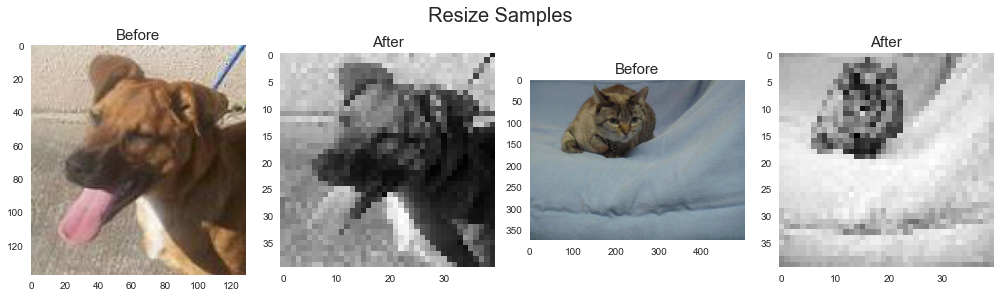

In [72]:
# X_40g, y_40g = prep_data(strat_train_set["path"], 40, 40, 1, is_canny=False)
# joblib.dump(X_40g, "dogs-vs-cats/data/X_40g.pkl")
# joblib.dump(y_40g, "dogs-vs-cats/data/y_40g.pkl")

X_40g = joblib.load(r"dogs-vs-cats/data/X_40g.pkl")
y_40g = joblib.load(r"dogs-vs-cats/data/y_40g.pkl")
set_params(40, 40, 1, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_40g.shape)
print("Target shape:", y_40g.shape)

plot_before_after(X_40g[0], X_40g[1])

X_40g = StandardScaler().fit_transform(X_40g)

In [73]:
# log_reg_40g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40g.fit(X_40g, y_40g)
# joblib.dump(log_reg_40g, "dogs-vs-cats/models/log_reg_40g.pkl")
log_reg_40g = joblib.load(r"dogs-vs-cats/models/log_reg_40g.pkl")

In [74]:
# log_reg_40g_pred = log_reg_40g.predict(X_40g)
# joblib.dump(log_reg_40g_pred, "dogs-vs-cats/pred/log_reg_40g_pred.pkl")
log_reg_40g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40g_pred.pkl")
metrics.accuracy_score(y_40g, log_reg_40g_pred)

0.63075

In [75]:
# log_reg_40g_scores = cross_val_score(log_reg_40g, X_40g, y_40g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40g_scores, "dogs-vs-cats/scores/log_reg_40g_scores.pkl")
log_reg_40g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40g_scores.pkl")
display_scores(log_reg_40g_scores)

Scores: [0.5308 0.5226 0.5256 0.5284]
Mean: 0.52685
Standard Deviation: 0.00307


> ### 40x40 Canny

Data shape: (20000, 1600)
Target shape: (20000,)


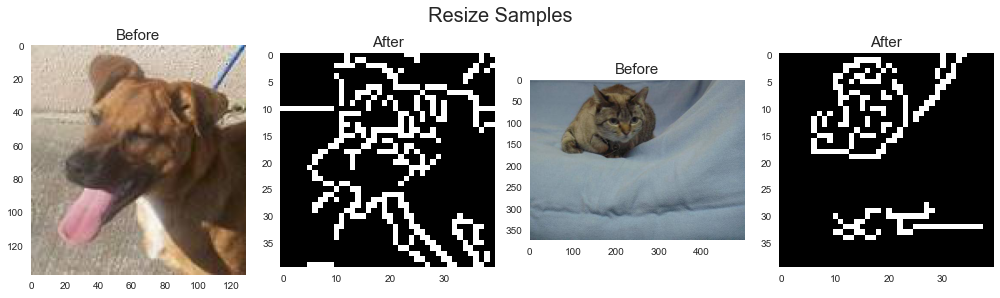

In [76]:
# X_40C, y_40C = prep_data(strat_train_set["path"], 40, 40, 1, is_canny=True)
# joblib.dump(X_40C, "dogs-vs-cats/data/X_40C.pkl")
# joblib.dump(y_40C, "dogs-vs-cats/data/y_40C.pkl")

X_40C = joblib.load(r"dogs-vs-cats/data/X_40C.pkl")
y_40C = joblib.load(r"dogs-vs-cats/data/y_40C.pkl")
set_params(40, 40, 1, is_canny=True)

# data shape (rows, columns)
print("Data shape:", X_40C.shape)
print("Target shape:", y_40C.shape)

plot_before_after(X_40C[0], X_40C[1])

X_40C = StandardScaler().fit_transform(X_40C)

In [77]:
# log_reg_40C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40C.fit(X_40C, y_40C)
# joblib.dump(log_reg_40C, "dogs-vs-cats/models/log_reg_40C.pkl")
log_reg_40C = joblib.load(r"dogs-vs-cats/models/log_reg_40C.pkl")

In [78]:
# log_reg_40C_pred = log_reg_40C.predict(X_40C)
# joblib.dump(log_reg_40C_pred, "dogs-vs-cats/pred/log_reg_40C_pred.pkl")
log_reg_40C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40C_pred.pkl")
metrics.accuracy_score(y_40C, log_reg_40C_pred)

0.67395

In [79]:
# log_reg_40C_scores = cross_val_score(log_reg_40C, X_40C, y_40C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40C_scores, "dogs-vs-cats/scores/log_reg_40C_scores.pkl")
log_reg_40C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40C_scores.pkl")
display_scores(log_reg_40C_scores)

Scores: [0.58   0.5854 0.5892 0.5828]
Mean: 0.58435
Standard Deviation: 0.00339


## Pixels: 50x50

> ### 50x50x3 Color

Data shape: (20000, 7500)
Target shape: (20000,)


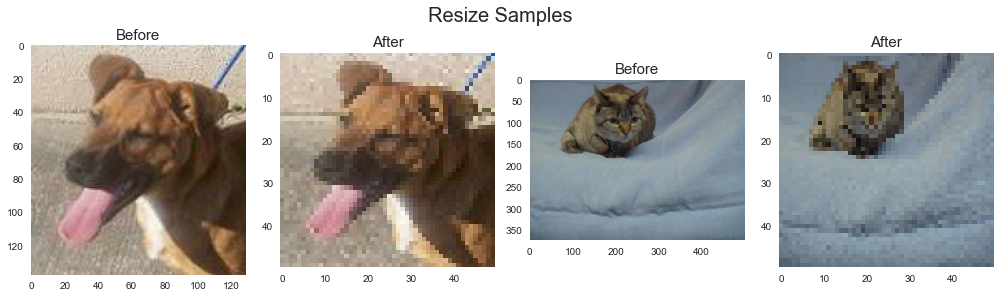

In [80]:
# X_50, y_50 = prep_data(strat_train_set["path"], 50, 50, 3, is_canny=False)
# joblib.dump(X_50, "dogs-vs-cats/data/X_50.pkl")
# joblib.dump(y_50, "dogs-vs-cats/data/y_50.pkl")

X_50 = joblib.load(r"dogs-vs-cats/data/X_50.pkl")
y_50 = joblib.load(r"dogs-vs-cats/data/y_50.pkl")
set_params(50, 50, 3, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_50.shape)
print("Target shape:", y_50.shape)

plot_before_after(X_50[0], X_50[1])

X_50 = StandardScaler().fit_transform(X_50)

In [81]:
# log_reg_50 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50.fit(X_50, y_50)
# joblib.dump(log_reg_50, "dogs-vs-cats/models/log_reg_50.pkl")
log_reg_50 = joblib.load(r"dogs-vs-cats/models/log_reg_50.pkl")

In [82]:
# log_reg_50_pred = log_reg_50.predict(X_50)
# joblib.dump(log_reg_50_pred, "dogs-vs-cats/pred/log_reg_50_pred.pkl")
log_reg_50_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50_pred.pkl")
metrics.accuracy_score(y_50, log_reg_50_pred)

0.7192

In [83]:
# log_reg_50_scores = cross_val_score(log_reg_50, X_50, y_50, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50_scores, "dogs-vs-cats/scores/log_reg_50_scores.pkl")
log_reg_50_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50_scores.pkl")
display_scores(log_reg_50_scores)

Scores: [0.5674 0.5666 0.5694 0.5742]
Mean: 0.5694
Standard Deviation: 0.00295


> ### 50x50 Grayscale

Data shape: (20000, 2500)
Target shape: (20000,)


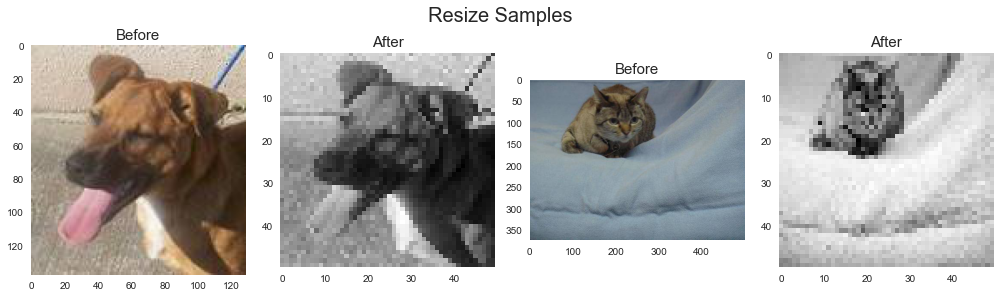

In [84]:
# X_50g, y_50g = prep_data(strat_train_set["path"], 50, 50, 1, is_canny=False)
# joblib.dump(X_50g, "dogs-vs-cats/data/X_50g.pkl")
# joblib.dump(y_50g, "dogs-vs-cats/data/y_50g.pkl")

X_50g = joblib.load(r"dogs-vs-cats/data/X_50g.pkl")
y_50g = joblib.load(r"dogs-vs-cats/data/y_50g.pkl")
set_params(50, 50, 1, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_50g.shape)
print("Target shape:", y_50g.shape)

plot_before_after(X_50g[0], X_50g[1])

X_50g = StandardScaler().fit_transform(X_50g)

In [85]:
# log_reg_50g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50g.fit(X_50g, y_50g)
# joblib.dump(log_reg_50g, "dogs-vs-cats/models/log_reg_50g.pkl")
log_reg_50g = joblib.load(r"dogs-vs-cats/models/log_reg_50g.pkl")

In [86]:
# log_reg_50g_pred = log_reg_50g.predict(X_50g)
# joblib.dump(log_reg_50g_pred, "dogs-vs-cats/pred/log_reg_50g_pred.pkl")
log_reg_50g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50g_pred.pkl")
metrics.accuracy_score(y_50g, log_reg_50g_pred)

0.66085

In [87]:
# log_reg_50g_scores = cross_val_score(log_reg_50g, X_50g, y_50g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50g_scores, "dogs-vs-cats/scores/log_reg_50g_scores.pkl")
log_reg_50g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50g_scores.pkl")
display_scores(log_reg_50g_scores)

Scores: [0.5278 0.5258 0.5222 0.5408]
Mean: 0.52915
Standard Deviation: 0.00702


> ### 50x50 Canny

Data shape: (20000, 2500)
Target shape: (20000,)


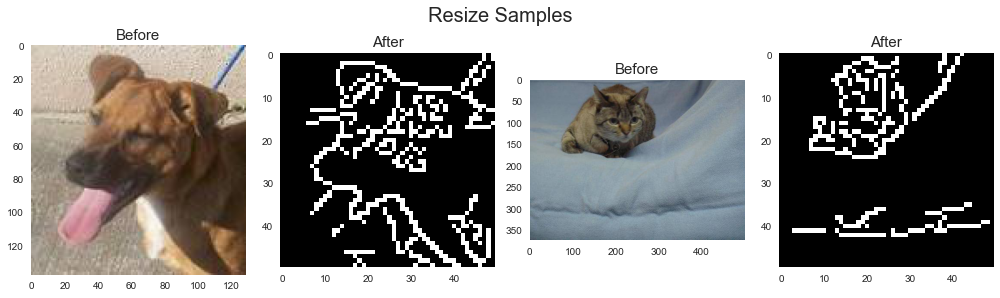

In [88]:
# X_50C, y_50C = prep_data(strat_train_set["path"], 50, 50, 1, is_canny=True)
# joblib.dump(X_50C, "dogs-vs-cats/data/X_50C.pkl")
# joblib.dump(y_50C, "dogs-vs-cats/data/y_50C.pkl")

X_50C = joblib.load(r"dogs-vs-cats/data/X_50C.pkl")
y_50C = joblib.load(r"dogs-vs-cats/data/y_50C.pkl")
set_params(50, 50, 1, is_canny=True)

# data shape (rows, columns)
print("Data shape:", X_50C.shape)
print("Target shape:", y_50C.shape)

plot_before_after(X_50C[0], X_50C[1])

X_50C = StandardScaler().fit_transform(X_50C)

In [89]:
# log_reg_50C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50C.fit(X_50C, y_50C)
# joblib.dump(log_reg_50C, "dogs-vs-cats/models/log_reg_50C.pkl")
log_reg_50C = joblib.load(r"dogs-vs-cats/models/log_reg_50C.pkl")

In [90]:
# log_reg_50C_pred = log_reg_50C.predict(X_50C)
# joblib.dump(log_reg_50C_pred, "dogs-vs-cats/pred/log_reg_50C_pred.pkl")
log_reg_50C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50C_pred.pkl")
metrics.accuracy_score(y_50C, log_reg_50C_pred)

0.69355

In [91]:
# log_reg_50C_scores = cross_val_score(log_reg_50C, X_50C, y_50C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50C_scores, "dogs-vs-cats/scores/log_reg_50C_scores.pkl")
log_reg_50C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50C_scores.pkl")
display_scores(log_reg_50C_scores)

Scores: [0.571  0.5692 0.5696 0.5574]
Mean: 0.5668
Standard Deviation: 0.00547


* As the size increases, the model fits the training set better (perhaps sometimes overfitting it).
However, cross-validation accuracy decreased, meaning that the models performed worse
on unseen data.
* Grayscale had the lowest accuracy in each scale.

## 30x30x3 Color vs. 30x30 Canny

The transformations have narrowed down to two options: 30x30 color and canny.

To help decide which is better, I'll train 2 additional simple baseline models:
KNN and Decision Tree Classifier.
The diverse algorithms should help decide which transformation is better.

> ### 30x30x3 Color: KNN, Decision Tree

In [92]:
# knn_clf_30 = KNeighborsClassifier(n_jobs=-1)
# knn_clf_30.fit(X_30, y_30)
# joblib.dump(knn_clf_30, "dogs-vs-cats/models/knn_clf_30.pkl")
knn_clf_30 = joblib.load(r"dogs-vs-cats/models/knn_clf_30.pkl")

# tree_clf_30 = DecisionTreeClassifier(random_state=42)
# tree_clf_30.fit(X_30, y_30)
# joblib.dump(tree_clf_30, "dogs-vs-cats/models/tree_clf_30.pkl")
tree_clf_30 = joblib.load(r"dogs-vs-cats/models/tree_clf_30.pkl")

In [93]:
# knn_clf_30_pred = knn_clf_30.predict(X_30)
# joblib.dump(knn_clf_30_pred, "dogs-vs-cats/pred/knn_clf_30_pred.pkl")
knn_clf_30_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_30_pred.pkl")
print("KNN:", metrics.accuracy_score(y_30, knn_clf_30_pred))

# tree_clf_30_pred = tree_clf_30.predict(X_30)
# joblib.dump(tree_clf_30_pred, "dogs-vs-cats/pred/tree_clf_30_pred.pkl")
tree_clf_30_pred = joblib.load(r"dogs-vs-cats/pred/tree_clf_30_pred.pkl")
print("Decision Tree:", metrics.accuracy_score(y_30, tree_clf_30_pred))

KNN: 0.69635
Decision Tree: 1.0


In [94]:
# knn_clf_30_scores = cross_val_score(knn_clf_30, X_30, y_30, scoring="accuracy", cv=4)
# joblib.dump(knn_clf_30_scores, "dogs-vs-cats/scores/knn_clf_30_scores.pkl")
knn_clf_30_scores = joblib.load(r"dogs-vs-cats/scores/knn_clf_30_scores.pkl")
print("KNN scores:")
display_scores(knn_clf_30_scores)

# tree_clf_30_scores = cross_val_score(tree_clf_30, X_30, y_30, scoring="accuracy", cv=4)
# joblib.dump(tree_clf_30_scores, "dogs-vs-cats/scores/tree_clf_30_scores.pkl")
tree_clf_30_scores = joblib.load(r"dogs-vs-cats/scores/tree_clf_30_scores.pkl")
print("Decision Tree scores:")
display_scores(tree_clf_30_scores)

KNN scores:
Scores: [0.5498 0.5586 0.5552 0.5334]
Mean: 0.54925
Standard Deviation: 0.00967
Decision Tree scores:
Scores: [0.5548 0.5592 0.5546 0.5622]
Mean: 0.5577
Standard Deviation: 0.00318


> ### 30x30 Canny: KNN, Decision Tree

In [95]:
# knn_clf_30C = KNeighborsClassifier(n_jobs=-1)
# knn_clf_30C.fit(X_30C, y_30C)
# joblib.dump(knn_clf_30C, "dogs-vs-cats/models/knn_clf_30C.pkl")
knn_clf_30C = joblib.load(r"dogs-vs-cats/models/knn_clf_30C.pkl")

# tree_clf_30C = DecisionTreeClassifier(random_state=42)
# tree_clf_30C.fit(X_30C, y_30C)
# joblib.dump(tree_clf_30C, "dogs-vs-cats/models/tree_clf_30C.pkl")
tree_clf_30C = joblib.load(r"dogs-vs-cats/models/tree_clf_30C.pkl")

In [96]:
# knn_clf_30C_pred = knn_clf_30C.predict(X_30C)
# joblib.dump(knn_clf_30C_pred, "dogs-vs-cats/pred/knn_clf_30C_pred.pkl")
knn_clf_30C_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_30C_pred.pkl")
print("KNN:", metrics.accuracy_score(y_30C, knn_clf_30C_pred))

# tree_clf_30C_pred = tree_clf_30C.predict(X_30C)
# joblib.dump(tree_clf_30C_pred, "dogs-vs-cats/pred/tree_clf_30C_pred.pkl")
tree_clf_30C_pred = joblib.load(r"dogs-vs-cats/pred/tree_clf_30C_pred.pkl")
print("Decision Tree:", metrics.accuracy_score(y_30C, tree_clf_30C_pred))

KNN: 0.71715
Decision Tree: 1.0


In [97]:
# knn_clf_30C_scores = cross_val_score(knn_clf_30C, X_30C, y_30C, scoring="accuracy", cv=4)
# joblib.dump(knn_clf_30C_scores, "dogs-vs-cats/scores/knn_clf_30C_scores.pkl")
knn_clf_30C_scores = joblib.load(r"dogs-vs-cats/scores/knn_clf_30C_scores.pkl")
print("KNN scores:")
display_scores(knn_clf_30C_scores)

# tree_clf_30C_scores = cross_val_score(tree_clf_30C, X_30C, y_30C, scoring="accuracy", cv=4)
# joblib.dump(tree_clf_30C_scores, "dogs-vs-cats/scores/tree_clf_30C_scores.pkl")
tree_clf_30C_scores = joblib.load(r"dogs-vs-cats/scores/tree_clf_30C_scores.pkl")
print("Decision Tree scores:")
display_scores(tree_clf_30C_scores)

KNN scores:
Scores: [0.5072 0.5064 0.513  0.5032]
Mean: 0.50745
Standard Deviation: 0.00354
Decision Tree scores:
Scores: [0.5326 0.5302 0.5254 0.522 ]
Mean: 0.52755
Standard Deviation: 0.00412


> #### Observations:
* Although the Logistic Regression showed optimistic results for both transformations, the images in color
clearly have a higher accuracy on the additional models, making it the optimal transformation.

---

In [98]:
# load clean copy of the training set with chosen pre-processing transformations (scale 30x30x3)
X_train, y_train = prep_data(strat_train_set["path"], 30, 30, 3, False)

Loading: 0/20000
Loading: 5000/20000
Loading: 10000/20000
Loading: 15000/20000
Finished Loading Data


In [100]:
# transform training data using pipeline
X_train_prepared = full_pipeline.fit_transform(X_train)

# 4. Training and Evaluating Models

In [101]:
# function prints scores
def display_evaluation(actual, pred):
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", metrics.classification_report(actual, pred))

# function for evaluating cross validation scores and for easy model comparison
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 5))
    print("Standard Deviation:", round(scores.std(), 5))

def display_confusion_matrix(estimator, X, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    metrics.plot_confusion_matrix(estimator, X, y, cmap="Blues", ax=ax)
    plt.grid(False)
    plt.show()

### Shortlist Promising Models:
> Trying many models quickly and selecting the ones that show promising results.
>
>> How I plan to do this:
1. Train a baseline model and evaluate sample predictions.
2. Use cross-validation and evaluate scores.
3. If the model has a significant hyperparameters, try changing it. Use cross-validation to
compare the results to step 2.

In [102]:
# a few instances from the training data for testing
some_data = X_train[:10]
some_labels = y_train[:10]
some_data_prepared = full_pipeline.transform(some_data)

### Dummy Classifier

In [103]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42) # stratified uses training set class distribution
dummy_clf.fit(X_train_prepared, y_train)
dummy_clf_pred = cross_val_predict(dummy_clf, X_train_prepared, y_train, cv=4)
display_evaluation(y_train, dummy_clf_pred)

Confusion Matrix:
 [[4964 5036]
 [5036 4964]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50     10000
           1       0.50      0.50      0.50     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



### 1. Logistic Regression

In [104]:
log_reg = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg.fit(X_train_prepared, y_train)
# joblib.dump(log_reg, "dogs-vs-cats/models/log_reg_1.pkl")
log_reg = joblib.load(r"dogs-vs-cats/models/log_reg_1.pkl")

print("Predictions:", log_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [1 0 0 1 1 0 0 1 0 0]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [105]:
# log_reg_scores_1 = cross_val_score(log_reg, X_train_prepared, y_train, scoring='accuracy', cv=4)
# joblib.dump(log_reg_scores_1, "dogs-vs-cats/scores/log_reg_scores_1.pkl")
log_reg_scores_1 = joblib.load(r"dogs-vs-cats/scores/log_reg_scores_1.pkl")
display_scores(log_reg_scores_1)

Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


### 2. KNN

In [106]:
# using default weights (uniform)
# using default n_neighbors (n = 5)
knn_clf = KNeighborsClassifier(n_jobs=-1)
# knn_clf.fit(X_train_prepared, y_train)
# joblib.dump(knn_clf, "dogs-vs-cats/models/knn_clf_2.pkl")
knn_clf = joblib.load(r"dogs-vs-cats/models/knn_clf_2.pkl")

print("Predictions:", knn_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [107]:
# knn_scores_2 = cross_val_score(knn_clf, X_train_prepared, y_train, scoring='accuracy', cv=4)
# joblib.dump(knn_scores_2, "dogs-vs-cats/scores/knn_scores_2.pkl")
knn_scores_2 = joblib.load(r"dogs-vs-cats/scores/knn_scores_2.pkl")
display_scores(knn_scores_2)

Scores: [0.5498 0.5586 0.5552 0.5334]
Mean: 0.54925
Standard Deviation: 0.00967


### 3. Decision Tree Classifier

In [108]:
tree_clf = DecisionTreeClassifier(random_state=42)
# tree_clf.fit(X_train_prepared, y_train)
# joblib.dump(tree_clf, "dogs-vs-cats/models/tree_clf_3.pkl")
tree_clf = joblib.load(r"dogs-vs-cats/models/tree_clf_3.pkl")

print("Predictions:", tree_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [109]:
# tree_scores_3 = cross_val_score(tree_clf, X_train_prepared, y_train, scoring='accuracy', cv=4, n_jobs=-1)
# joblib.dump(tree_scores_3, "dogs-vs-cats/scores/tree_scores_3.pkl")
tree_scores_3 = joblib.load(r"dogs-vs-cats/scores/tree_scores_3.pkl")
display_scores(tree_scores_3)

Scores: [0.5548 0.5592 0.5546 0.5622]
Mean: 0.5577
Standard Deviation: 0.00318


### 4. Random Forest Classifier

In [110]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
# rf_clf.fit(X_train_prepared, y_train)
# joblib.dump(rf_clf, "dogs-vs-cats/models/rf_clf_4.pkl")
rf_clf = joblib.load(r"dogs-vs-cats/models/rf_clf_4.pkl")

print("Predictions:", rf_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [111]:
# rf_scores_4 = cross_val_score(rf_clf, X_train_prepared, y_train, scoring='accuracy', cv=4)
# joblib.dump(rf_scores_4, "dogs-vs-cats/scores/rf_scores_4.pkl")
rf_scores_4 = joblib.load(r"dogs-vs-cats/scores/rf_scores_4.pkl")
display_scores(rf_scores_4)

Scores: [0.6448 0.6324 0.6392 0.6432]
Mean: 0.6399
Standard Deviation: 0.00479


> Now that we have 4 different baseline models, lets evaluate dimensionality reduction techniques.

> ### KMeans Clustering

### 5. Logistic Regression

> Before Clustering:

In [112]:
display_scores(log_reg_scores_1)

Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


> After Clustering:

In [113]:
kmeans_log_reg = Pipeline([
    ("kmeans", KMeans()),
    ("log_reg", LogisticRegression(random_state=42))
])

param_grid = dict(kmeans__n_clusters=range(2,70))

In [114]:
# kmeans_log_reg_grid = GridSearchCV(kmeans_log_reg, param_grid, cv=4, scoring="accuracy", verbose=2, n_jobs=-1)
# kmeans_log_reg_grid.fit(X_train_prepared, y_train)
# joblib.dump(kmeans_log_reg_grid, "dogs-vs-cats/scores/kmeans_log_reg_grid.pkl")
kmeans_log_reg_grid = joblib.load(r"dogs-vs-cats/scores/kmeans_log_reg_grid.pkl")

In [115]:
kmeans_log_reg_grid.best_params_

{'kmeans__n_clusters': 63}

In [116]:
kmeans_log_reg_grid.best_score_

0.59655

In [117]:
# show results for each iteration
cvres = kmeans_log_reg_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.5497 {'kmeans__n_clusters': 2}
0.55725 {'kmeans__n_clusters': 3}
0.562 {'kmeans__n_clusters': 4}
0.5621 {'kmeans__n_clusters': 5}
0.5617 {'kmeans__n_clusters': 6}
0.5628 {'kmeans__n_clusters': 7}
0.5704 {'kmeans__n_clusters': 8}
0.56565 {'kmeans__n_clusters': 9}
0.57215 {'kmeans__n_clusters': 10}
0.57725 {'kmeans__n_clusters': 11}
0.58105 {'kmeans__n_clusters': 12}
0.58075 {'kmeans__n_clusters': 13}
0.58005 {'kmeans__n_clusters': 14}
0.58015 {'kmeans__n_clusters': 15}
0.5797 {'kmeans__n_clusters': 16}
0.5805 {'kmeans__n_clusters': 17}
0.58195 {'kmeans__n_clusters': 18}
0.58125 {'kmeans__n_clusters': 19}
0.5822 {'kmeans__n_clusters': 20}
0.58295 {'kmeans__n_clusters': 21}
0.586 {'kmeans__n_clusters': 22}
0.5848 {'kmeans__n_clusters': 23}
0.58415 {'kmeans__n_clusters': 24}
0.587 {'kmeans__n_clusters': 25}
0.59015 {'kmeans__n_clusters': 26}
0.58655 {'kmeans__n_clusters': 27}
0.59045 {'kmeans__n_clusters': 28}
0.59165 {'kmeans__n_clusters': 29}
0.58505 {'kmeans__n_clusters': 30}
0.5888 {

### 6. Random Forest

> Random Forest before Clustering:

In [118]:
display_scores(rf_scores_4)

Scores: [0.6448 0.6324 0.6392 0.6432]
Mean: 0.6399
Standard Deviation: 0.00479


> Random Forest after Clustering:

In [119]:
kmeans_rf_clf = Pipeline([
    ("kmeans", KMeans()),
    ("rf_clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [120]:
# kmeans_rf_clf_grid = GridSearchCV(kmeans_rf_clf, param_grid, cv=4, scoring="accuracy", verbose=2)
# kmeans_rf_clf_grid.fit(X_train_prepared, y_train)
# joblib.dump(kmeans_rf_clf_grid, "dogs-vs-cats/scores/kmeans_rf_clf_grid.pkl")
kmeans_rf_clf_grid = joblib.load(r"dogs-vs-cats/scores/kmeans_rf_clf_grid.pkl")

In [121]:
kmeans_rf_clf_grid.best_params_

{'kmeans__n_clusters': 68}

In [122]:
kmeans_rf_clf_grid.best_score_

0.5943499999999999

In [123]:
# show results for each iteration
cvres = kmeans_rf_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.51845 {'kmeans__n_clusters': 2}
0.53945 {'kmeans__n_clusters': 3}
0.5411 {'kmeans__n_clusters': 4}
0.5489 {'kmeans__n_clusters': 5}
0.55145 {'kmeans__n_clusters': 6}
0.562 {'kmeans__n_clusters': 7}
0.5634 {'kmeans__n_clusters': 8}
0.56385 {'kmeans__n_clusters': 9}
0.5641 {'kmeans__n_clusters': 10}
0.56325 {'kmeans__n_clusters': 11}
0.5672 {'kmeans__n_clusters': 12}
0.56345 {'kmeans__n_clusters': 13}
0.56915 {'kmeans__n_clusters': 14}
0.56635 {'kmeans__n_clusters': 15}
0.5641 {'kmeans__n_clusters': 16}
0.56825 {'kmeans__n_clusters': 17}
0.5689 {'kmeans__n_clusters': 18}
0.56905 {'kmeans__n_clusters': 19}
0.5699 {'kmeans__n_clusters': 20}
0.5716 {'kmeans__n_clusters': 21}
0.573 {'kmeans__n_clusters': 22}
0.57345 {'kmeans__n_clusters': 23}
0.57705 {'kmeans__n_clusters': 24}
0.5736 {'kmeans__n_clusters': 25}
0.5782 {'kmeans__n_clusters': 26}
0.57505 {'kmeans__n_clusters': 27}
0.58155 {'kmeans__n_clusters': 28}
0.57805 {'kmeans__n_clusters': 29}
0.5807 {'kmeans__n_clusters': 30}
0.5774 {'

> ### PCA

In [124]:
pca = PCA()
pca.fit(X_train_prepared)
# cumulative sum (increasing by sequential addition) of components
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

582

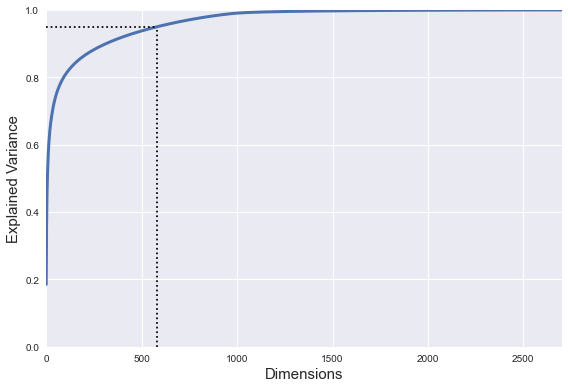

In [125]:
plt.axis([0, 2700, 0, 1])  # axis limits
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions", size=15)
plt.ylabel("Explained Variance", size=15)
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.tight_layout()
plt.show()

> Using the elbow method, around 95% explained variance is where the graph starts growing slower.
>
> For instance, reducing the dimensions from 2700 down to 582 will preserve 95% of the variance with only
> a little data loss.
>
> I will use cross-validation on the transformed data in the range of 85-95 percent explained variance
> to determine which is the optimal choice.

### 7. Logistic Regression

> Before PCA:

In [126]:
display_scores(log_reg_scores_1)

Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


> After PCA:

In [127]:
pca_log_reg = Pipeline([
    ("pca", PCA()),
    ("log_reg", LogisticRegression(random_state=42))
])

param_grid = [{
    "pca__n_components": [0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]
}]

In [128]:
# pca_log_reg_grid = GridSearchCV(pca_log_reg, param_grid, cv=4, scoring="accuracy", verbose=2, n_jobs=-1)
# pca_log_reg_grid.fit(X_train_prepared, y_train)
# joblib.dump(pca_log_reg_grid, "dogs-vs-cats/scores/pca_log_reg_grid.pkl")
pca_log_reg_grid = joblib.load(r"dogs-vs-cats/scores/pca_log_reg_grid.pkl")

In [129]:
pca_log_reg_grid.best_params_

{'pca__n_components': 0.9}

In [130]:
pca_log_reg_grid.best_score_

0.6097

In [131]:
# show results for each iteration
cvres = pca_log_reg_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.5941500000000001 {'pca__n_components': 0.85}
0.60795 {'pca__n_components': 0.86}
0.60705 {'pca__n_components': 0.87}
0.6092500000000001 {'pca__n_components': 0.88}
0.60865 {'pca__n_components': 0.89}
0.6097 {'pca__n_components': 0.9}
0.6084 {'pca__n_components': 0.91}
0.6060500000000001 {'pca__n_components': 0.92}
0.60485 {'pca__n_components': 0.93}
0.6035 {'pca__n_components': 0.94}
0.60205 {'pca__n_components': 0.95}


### 8. Random Forest

> Random Forest before PCA:

In [132]:
display_scores(rf_scores_4)

Scores: [0.6448 0.6324 0.6392 0.6432]
Mean: 0.6399
Standard Deviation: 0.00479


> Random Forest after PCA:

In [133]:
pca_rf_clf = Pipeline([
    ("pca", PCA()),
    ("rf_clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [134]:
# pca_rf_clf_grid = GridSearchCV(pca_rf_clf, param_grid, cv=4, scoring="accuracy", verbose=2)
# pca_rf_clf_grid.fit(X_train_prepared, y_train)
# joblib.dump(pca_rf_clf_grid, "dogs-vs-cats/scores/pca_rf_clf_grid.pkl")
pca_rf_clf_grid = joblib.load(r"dogs-vs-cats/scores/pca_rf_clf_grid.pkl")

In [135]:
pca_rf_clf_grid.best_params_

{'pca__n_components': 0.86}

In [136]:
pca_rf_clf_grid.best_score_

0.62005

In [137]:
# show results for each iteration
cvres = pca_rf_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6195499999999999 {'pca__n_components': 0.85}
0.62005 {'pca__n_components': 0.86}
0.6166 {'pca__n_components': 0.87}
0.6146499999999999 {'pca__n_components': 0.88}
0.6153 {'pca__n_components': 0.89}
0.61395 {'pca__n_components': 0.9}
0.6119 {'pca__n_components': 0.91}
0.61175 {'pca__n_components': 0.92}
0.61525 {'pca__n_components': 0.93}
0.60785 {'pca__n_components': 0.94}
0.6043999999999999 {'pca__n_components': 0.95}


### 9. KNN

> KNN before PCA:

In [138]:
display_scores(knn_scores_2)

Scores: [0.5498 0.5586 0.5552 0.5334]
Mean: 0.54925
Standard Deviation: 0.00967


> KNN after PCA:

In [139]:
pca_knn_clf = Pipeline([
    ("pca", PCA()),
    ("knn_clf", KNeighborsClassifier(n_jobs=-1))
])

In [140]:
# pca_knn_clf_grid = GridSearchCV(pca_knn_clf, param_grid, cv=4, scoring="accuracy", verbose=2)
# pca_knn_clf_grid.fit(X_train_prepared, y_train)
# joblib.dump(pca_knn_clf_grid, "dogs-vs-cats/scores/pca_knn_clf_grid.pkl")
pca_knn_clf_grid = joblib.load(r"dogs-vs-cats/scores/pca_knn_clf_grid.pkl")

In [141]:
pca_knn_clf_grid.best_params_

{'pca__n_components': 0.86}

In [142]:
pca_knn_clf_grid.best_score_

0.5890500000000001

In [143]:
# show results for each iteration
cvres = pca_knn_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.58805 {'pca__n_components': 0.85}
0.5890500000000001 {'pca__n_components': 0.86}
0.5865 {'pca__n_components': 0.87}
0.5822 {'pca__n_components': 0.88}
0.5780000000000001 {'pca__n_components': 0.89}
0.5756000000000001 {'pca__n_components': 0.9}
0.5748 {'pca__n_components': 0.91}
0.5722 {'pca__n_components': 0.92}
0.56975 {'pca__n_components': 0.93}
0.5678 {'pca__n_components': 0.94}
0.5651 {'pca__n_components': 0.95}


In [144]:
d = np.argmax(cumsum >= 0.86) + 1
d

191

> Conclusion:
* We can achieve a higher accuracy with PCA.

In [145]:
# add PCA to pipeline
full_pipeline.steps.append(('pca', PCA(n_components=0.86)))
full_pipeline

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('pca', PCA(n_components=0.86))])

In [146]:
X_train_reduced = full_pipeline.fit_transform(X_train, y_train)
some_data_reduced = full_pipeline.transform(some_data)

### 10. Decision Tree

In [147]:
# tree_scores_10 = cross_val_score(clone(tree_clf), X_train_reduced, y_train, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# joblib.dump(tree_scores_10, "dogs-vs-cats/scores/tree_scores_10.pkl")
tree_scores_10 = joblib.load(r"dogs-vs-cats/scores/tree_scores_10.pkl")
display_scores(tree_scores_10)

Scores: [0.555  0.5402 0.5374 0.5392]
Mean: 0.54295
Standard Deviation: 0.00703


### 11. Extra Trees Classifier
> Very similar to the Random Forest classifier. The main difference is that Extra Trees randomly splits
> nodes, while Random Forest searches for the best split. Extra Trees is also faster to train due to this.
>> Note: Comparing prediction accuracy can help determine which model performs better on the data.

In [148]:
ex_trees = ExtraTreesClassifier(random_state=42, n_jobs=-1)
# ex_trees.fit(X_train_reduced, y_train)
# joblib.dump(ex_trees, "dogs-vs-cats/models/ex_trees_11.pkl")
ex_trees = joblib.load(r"dogs-vs-cats/models/ex_trees_11.pkl")

print("Predictions:", ex_trees.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [149]:
# ex_trees_scores_11 = cross_val_score(ex_trees, X_train_reduced, y_train, cv=4, scoring='accuracy', verbose=2)
# joblib.dump(ex_trees_scores_11, "dogs-vs-cats/scores/ex_trees_scores_11.pkl")
ex_trees_scores_11 = joblib.load(r"dogs-vs-cats/scores/ex_trees_scores_11.pkl")
display_scores(ex_trees_scores_11)

Scores: [0.6232 0.6098 0.6074 0.601 ]
Mean: 0.61035
Standard Deviation: 0.00809


> Comparing Extra Trees to Random Forest:

In [150]:
# rf_clf_scores_11 = cross_val_score(clone(rf_clf), X_train_reduced, y_train, cv=4, scoring='accuracy', verbose=2)
# joblib.dump(rf_clf_scores_11, "dogs-vs-cats/scores/rf_clf_scores_11.pkl")
rf_clf_scores_11 = joblib.load(r"dogs-vs-cats/scores/rf_clf_scores_11.pkl")
display_scores(rf_clf_scores_11)

Scores: [0.632  0.6126 0.6218 0.6258]
Mean: 0.62305
Standard Deviation: 0.00704


> Random Forest has a higher accuracy and a lower standard deviation, making it more reliable.

### 12. AdaBoost
> The AdaBoost (adaptive boosting) ensemble method trains a weak classifier, then increases the
> weights of the misclassified instances and trains another weak classifier on the dataset with the
> updated weights.

In [151]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), random_state=42)
# ada_clf.fit(X_train_reduced, y_train)
# joblib.dump(ada_clf, "dogs-vs-cats/models/ada_clf_12.pkl")
ada_clf = joblib.load(r"dogs-vs-cats/models/ada_clf_12.pkl")

print("Predictions:", ada_clf.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [152]:
# ada_scores_12 = cross_val_score(ada_clf, X_train_reduced, y_train, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# joblib.dump(ada_scores_12, "dogs-vs-cats/scores/ada_scores_12.pkl")
ada_scores_12 = joblib.load(r"dogs-vs-cats/scores/ada_scores_12.pkl")
display_scores(ada_scores_12)

Scores: [0.5612 0.5486 0.5336 0.546 ]
Mean: 0.54735
Standard Deviation: 0.0098


### 13. XGBoost
> The Gradient Boosting ensemble method that fits a new weak classifier to the errors
> made by the previous classifiers, then makes predictions on the combined classifiers.
>> Note: XGBoost (extreme gradient boosting) is a separate library from sklearn
> that contains an optimized version of gradient boosting.

In [153]:
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='error', objective='binary:logistic', use_label_encoder=False)
# xgb_clf.fit(X_train_reduced, y_train)
# joblib.dump(xgb_clf, "dogs-vs-cats/models/xgb_clf_13.pkl")
xgb_clf = joblib.load(r"dogs-vs-cats/models/xgb_clf_13.pkl")

print("Predictions:", xgb_clf.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [154]:
xgb_clf.best_iteration

99

In [155]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "error" # error rate = 1-accuracy
}

# dmatrix is a data structure used by the XGBoost library that optimizes performance
# it is needed when using the XGBoost library cross-validation
dmat_train = DMatrix(X_train_reduced, y_train)

In [156]:
# xgb_scores_13 = cv(params, dmat_train, num_boost_round=100, nfold=4,
#                   early_stopping_rounds=10, seed=42, metrics="error", verbose_eval=True)
# joblib.dump(xgb_scores_13, "dogs-vs-cats/scores/xgb_scores_13.pkl")
xgb_scores_13 = joblib.load(r"dogs-vs-cats/scores/xgb_scores_13.pkl")

In [157]:
curr_min = xgb_scores_13["test-error-mean"].argmin()
curr_min

47

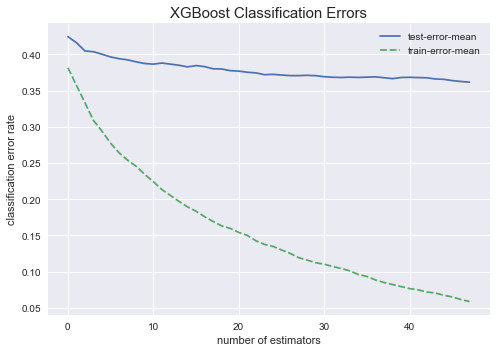

In [158]:
# plot classification errors from cross-validation
plt.figure(figsize=(7, 5))
sns.lineplot(data=[xgb_scores_13["test-error-mean"], xgb_scores_13["train-error-mean"]])
plt.xlabel("number of estimators")
plt.ylabel("classification error rate")
plt.title("XGBoost Classification Errors", size=15)
plt.tight_layout()
plt.show()

In [159]:
# best accuracy
1 - xgb_scores_13["test-error-mean"][curr_min]

0.63835

> #### Observations:
* The best models (from lowest to highest scores): KNN, Logistic Regression, Random Forest and XGBoost.
* Decision Tree and AdaBoost models had the lowest performance, both below 54% accuracy.

> ### Looking back:
>
> The best pre-processing steps and baseline models have been determined.
> The next step is to find the best hyperparameters for the models using Grid Search.

### Fine-Tune KNN

In [160]:
# knn_clf_pred = cross_val_predict(knn_clf, X_train_reduced, y_train, cv=4, verbose=2, n_jobs=-1)
# joblib.dump(knn_clf_pred, "dogs-vs-cats/pred/knn_clf_pred.pkl")
knn_clf_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_pred.pkl")
display_evaluation(y_train, knn_clf_pred)

Confusion Matrix:
 [[6047 3953]
 [4260 5740]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.60     10000
           1       0.59      0.57      0.58     10000

    accuracy                           0.59     20000
   macro avg       0.59      0.59      0.59     20000
weighted avg       0.59      0.59      0.59     20000



> KNN does not output probabilities, which means that it can only be used for hard voting.
A Voting Classifier using soft voting can not be used.

> Tuning weights and penalty:

In [161]:
param_grid = [{
    "weights": ['uniform', 'distance'],
    "p": [1, 2]
}]

In [162]:
# knn_clf_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# knn_clf_cv.fit(X_train_reduced, y_train)
# joblib.dump(knn_clf_cv, "dogs-vs-cats/scores/knn_clf_cv.pkl")
knn_clf_cv = joblib.load(r"dogs-vs-cats/scores/knn_clf_cv.pkl")

In [163]:
# show the best score
knn_clf_cv.best_score_

0.5897

In [164]:
# best estimator
knn_clf2 = knn_clf_cv.best_estimator_
knn_clf2

KNeighborsClassifier(weights='distance')

In [165]:
# show results for each iteration
cvres = knn_clf_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.57415 {'p': 1, 'weights': 'uniform'}
0.57465 {'p': 1, 'weights': 'distance'}
0.58935 {'p': 2, 'weights': 'uniform'}
0.5897 {'p': 2, 'weights': 'distance'}


> Tuning number of neighbors:
>> Note: There is an even number of classes. It is better to choose an odd number of neighbors to
>> prevent ties.

In [166]:
# larger k values are more computationally expensive
param_grid = [{
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
}]

In [167]:
# knn_clf_cv2 = GridSearchCV(knn_clf2, param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# knn_clf_cv2.fit(X_train_reduced, y_train)
# joblib.dump(knn_clf_cv2, "dogs-vs-cats/scores/knn_clf_cv2.pkl")
knn_clf_cv2 = joblib.load(r"dogs-vs-cats/scores/knn_clf_cv2.pkl")

In [168]:
# show the best score
knn_clf_cv2.best_score_

0.61165

In [169]:
# best estimator
knn_clf3 = knn_clf_cv2.best_estimator_
knn_clf3

KNeighborsClassifier(n_neighbors=27, weights='distance')

In [170]:
# show results for each iteration
cvres = knn_clf_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.5764 {'n_neighbors': 3}
0.5897 {'n_neighbors': 5}
0.5926 {'n_neighbors': 7}
0.5963 {'n_neighbors': 9}
0.60095 {'n_neighbors': 11}
0.60395 {'n_neighbors': 13}
0.603 {'n_neighbors': 15}
0.60695 {'n_neighbors': 17}
0.607 {'n_neighbors': 19}
0.60515 {'n_neighbors': 21}
0.6070500000000001 {'n_neighbors': 23}
0.6087 {'n_neighbors': 25}
0.61165 {'n_neighbors': 27}
0.6096499999999999 {'n_neighbors': 29}


> **Final KNN model:** Distance weights, l2 norm and 27 neighbors.

In [171]:
# knn_clf_final_pred = cross_val_predict(knn_clf3, X_train_reduced, y_train, cv=4, verbose=2, n_jobs=-1)
# joblib.dump(knn_clf_final_pred, "dogs-vs-cats/pred/knn_clf_final_pred.pkl")
knn_clf_final_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_final_pred.pkl")
display_evaluation(y_train, knn_clf_final_pred)

Confusion Matrix:
 [[5440 4560]
 [3207 6793]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.54      0.58     10000
           1       0.60      0.68      0.64     10000

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



### Fine-Tune Logistic Regression

In [172]:
# log_reg_pred = cross_val_predict(log_reg, X_train_reduced, y_train, cv=4, verbose=2, n_jobs=-1)
# joblib.dump(log_reg_pred, "dogs-vs-cats/pred/ log_reg_pred.pkl")
log_reg_pred = joblib.load(r"dogs-vs-cats/pred/ log_reg_pred.pkl")
display_evaluation(y_train, log_reg_pred)

Confusion Matrix:
 [[6156 3844]
 [3975 6025]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.62      0.61     10000
           1       0.61      0.60      0.61     10000

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



> Tuning solver and penalty:

In [173]:
# liblinear works well with smaller datasets
# uses a coordinate descent algorithm (moves toward the minimum one direction at a time)

# both sag and saga solvers work well with large datasets
# they are a variation of gradient descent
# convergence is faster when the data is scaled
# sag = stochastic average gradient, saga = variant of sag solver

param_grid = [{
     "solver": ["liblinear", "sag", "saga"]
}]

In [174]:
log_reg = LogisticRegression(random_state=42)
# log_reg_cv = GridSearchCV(log_reg, param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# log_reg_cv.fit(X_train_reduced, y_train)
# joblib.dump(log_reg_cv, "dogs-vs-cats/scores/log_reg_cv.pkl") # save local copy
log_reg_cv = joblib.load(r"dogs-vs-cats/scores/log_reg_cv.pkl")

In [175]:
# show the best score
log_reg_cv.best_score_

0.6091

In [176]:
# best estimator
log_reg2 = log_reg_cv.best_estimator_
log_reg2

LogisticRegression(random_state=42, solver='liblinear')

In [177]:
# show results for each iteration
cvres = log_reg_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6091 {'solver': 'liblinear'}
0.6091 {'solver': 'sag'}
0.60905 {'solver': 'saga'}


In [178]:
param_grid = [{
    "penalty": ["l1", "l2"], # liblinear supports l1 and l2 norms
    "C": [0.001, 0.05, 0.01, 0.1, 0.5, 1.]  # C controls regularization,
    # light penalty if close to 1.0, strong penalty if close to 0.0
}]

In [179]:
# log_reg_cv2 = GridSearchCV(log_reg2, param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# log_reg_cv2.fit(X_train_reduced, y_train)
# joblib.dump(log_reg_cv2, "dogs-vs-cats/scores/log_reg_cv2.pkl")
log_reg_cv2 = joblib.load(r"dogs-vs-cats/scores/log_reg_cv2.pkl")

In [180]:
# show the best score
log_reg_cv2.best_score_

0.6103999999999999

In [181]:
# best estimator
log_reg3 = log_reg_cv2.best_estimator_
log_reg3

LogisticRegression(C=0.05, penalty='l1', random_state=42, solver='liblinear')

In [182]:
# show results for each iteration
cvres = log_reg_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.583 {'C': 0.001, 'penalty': 'l1'}
0.6078 {'C': 0.001, 'penalty': 'l2'}
0.6103999999999999 {'C': 0.05, 'penalty': 'l1'}
0.60895 {'C': 0.05, 'penalty': 'l2'}
0.6066 {'C': 0.01, 'penalty': 'l1'}
0.6086 {'C': 0.01, 'penalty': 'l2'}
0.60885 {'C': 0.1, 'penalty': 'l1'}
0.6092000000000001 {'C': 0.1, 'penalty': 'l2'}
0.6092 {'C': 0.5, 'penalty': 'l1'}
0.6091 {'C': 0.5, 'penalty': 'l2'}
0.60895 {'C': 1.0, 'penalty': 'l1'}
0.6091 {'C': 1.0, 'penalty': 'l2'}


> **Final Logistic Regression model:** Liblinear solver, l1 norm and 0.05 penalty.

In [183]:
# log_reg_final_pred = cross_val_predict(log_reg3, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(log_reg_final_pred, "dogs-vs-cats/pred/log_reg_final_pred.pkl")
log_reg_final_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_final_pred.pkl")
display_evaluation(y_train, log_reg_final_pred)

Confusion Matrix:
 [[6167 3833]
 [3959 6041]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.62      0.61     10000
           1       0.61      0.60      0.61     10000

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



### Fine-Tune Random Forest

In [184]:
# rf_clf_pred = cross_val_predict(rf_clf, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(rf_clf_pred, "dogs-vs-cats/pred/rf_clf_pred.pkl")
rf_clf_pred = joblib.load(r"dogs-vs-cats/pred/rf_clf_pred.pkl")
display_evaluation(y_train, rf_clf_pred)

Confusion Matrix:
 [[6429 3571]
 [3968 6032]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63     10000
           1       0.63      0.60      0.62     10000

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



> Tuning maximum number features per tree:
>> Note: If this hyperparameter is set to 'None', it evaluates all features. When dealing with high
> dimensional data (such as image classification) it can be convenient to select a smaller amount
> of features.

In [185]:
param_grid = [{
    "max_features": ['sqrt', "log2", 0.1, 0.2, 0.5, 0.8, None]  # max features that are evaluated before splitting a node
}]

In [186]:
# rf_clf_cv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=4, scoring='accuracy', verbose=2)
# rf_clf_cv.fit(X_train_reduced, y_train)
# joblib.dump(rf_clf_cv, "dogs-vs-cats/scores/rf_clf_cv.pkl")
rf_clf_cv = joblib.load(r"dogs-vs-cats/scores/rf_clf_cv.pkl")

In [187]:
# show the best score
rf_clf_cv.best_score_

0.6286

In [188]:
# best estimator
rf_clf2 = rf_clf_cv.best_estimator_
rf_clf2

RandomForestClassifier(max_features=0.1, random_state=42)

In [189]:
# show results for each iteration
cvres = rf_clf_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.62305 {'max_features': 'sqrt'}
0.61145 {'max_features': 'log2'}
0.6286 {'max_features': 0.1}
0.6275999999999999 {'max_features': 0.2}
0.62705 {'max_features': 0.5}
0.6262 {'max_features': 0.8}
0.6261000000000001 {'max_features': None}


> Tuning number of trees with Bagging and Pasting:
>> Note: More estimators tend to improve accuracy at the expense of increasing the computation time.
> Additionally, from a certain amount of trees the model performance does not change much.

In [190]:
param_grid = [{
    "n_estimators": [50, 100, 200],  # max features in an individual tree
    "bootstrap": [True, False], # sampling with or without replacement
    # True (sklearn default) = bagging, False = pasting
    "criterion": ["gini", "entropy"] # function to measure quality of split
}]

In [191]:
# rf_clf_cv2 = GridSearchCV(rf_clf2, param_grid, cv=4, scoring="accuracy", verbose=2)
# rf_clf_cv2.fit(X_train_reduced, y_train)
# joblib.dump(rf_clf_cv2, "dogs-vs-cats/scores/rf_clf_cv2.pkl")
rf_clf_cv2 = joblib.load(r"dogs-vs-cats/scores/rf_clf_cv2.pkl")

In [192]:
# show the best score
rf_clf_cv2.best_score_

0.6476

In [193]:
# best estimator
rf_clf3 = rf_clf_cv2.best_estimator_
rf_clf3

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=0.1,
                       n_estimators=200, random_state=42)

In [194]:
# show results for each iteration
cvres = rf_clf_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6088 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 50}
0.6286 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100}
0.64205 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 200}
0.6138 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 50}
0.6274 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}
0.64015 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 200}
0.6157 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 50}
0.6346 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 100}
0.6424000000000001 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 200}
0.62155 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 50}
0.63965 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 100}
0.6476 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 200}


> **Final Extra Trees model:** 200 estimators, pasting method (sampling without replacement), and considers
> 0.1 features when splitting a node.

In [195]:
# rf_clf_final_pred = cross_val_predict(rf_clf3, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(rf_clf_final_pred, "dogs-vs-cats/pred/rf_clf_final_pred.pkl")
rf_clf_final_pred = joblib.load(r"dogs-vs-cats/pred/rf_clf_final_pred.pkl")
display_evaluation(y_train, rf_clf_final_pred)

Confusion Matrix:
 [[6562 3438]
 [3610 6390]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65     10000
           1       0.65      0.64      0.64     10000

    accuracy                           0.65     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.65      0.65      0.65     20000



### Fine-Tune XGBoost

In [196]:
# xgb_clf_pred = cross_val_predict(xgb_clf, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(xgb_clf_pred, "dogs-vs-cats/pred/xgb_clf_pred.pkl")
xgb_clf_pred = joblib.load(r"dogs-vs-cats/pred/xgb_clf_pred.pkl")
display_evaluation(y_train, xgb_clf_pred)

Confusion Matrix:
 [[6370 3630]
 [3562 6438]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.64      0.64     10000
           1       0.64      0.64      0.64     10000

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



> Tuning the number of estimators:

In [197]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "error"
}

In [198]:
# xgb_scores_cv1 = cv(params, dmat_train, num_boost_round=100, nfold=4,
#                    early_stopping_rounds=10, seed=42, metrics="error", verbose_eval=True)
# joblib.dump(xgb_scores_cv1, "dogs-vs-cats/scores/xgb_scores_cv1.pkl")
xgb_scores_cv1 = joblib.load(r"dogs-vs-cats/scores/xgb_scores_cv1.pkl")

In [199]:
curr_min = xgb_scores_cv1["test-error-mean"].argmin()
curr_min

47

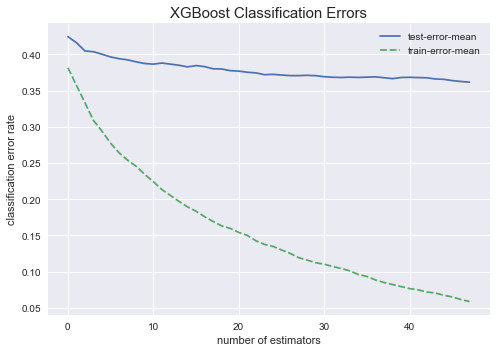

In [200]:
# plot classification errors from cross-validation
plt.figure(figsize=(7, 5))
sns.lineplot(data=[xgb_scores_cv1["test-error-mean"], xgb_scores_cv1["train-error-mean"]])
plt.xlabel("number of estimators")
plt.ylabel("classification error rate")
plt.title("XGBoost Classification Errors", size=15)
plt.tight_layout()
plt.show()

In [201]:
# best accuracy
1- xgb_scores_cv1["test-error-mean"][curr_min]

0.63835

> Tuning learning rate and tree depth:

In [202]:
param_grid = [{
    "max_depth": [3, 4, 5, 6], # maximum depth of a tree
    "learning_rate": [0.001, 0.05, 0.01, 0.1, 0.5, 1.] # controls the weights after every boost (eta)
}]

In [203]:
# xgb_scores_cv2 = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1, eval_metric='error', objective="binary:logistic",
#                        use_label_encoder=False, n_estimators=48), param_grid, cv=4, scoring='accuracy', verbose=2)
# xgb_scores_cv2.fit(X_train_reduced, y_train)
# joblib.dump(xgb_scores_cv2, "dogs-vs-cats/scores/xgb_scores_cv2.pkl")
xgb_scores_cv2 = joblib.load(r"dogs-vs-cats/scores/xgb_scores_cv2.pkl")

In [204]:
# show the best score
xgb_scores_cv2.best_score_

0.635

In [205]:
# best estimator
xgb_clf2 = xgb_scores_cv2.best_estimator_
xgb_clf2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=48, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [206]:
# show results for each iteration
cvres = xgb_scores_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.5668 {'learning_rate': 0.001, 'max_depth': 3}
0.5723 {'learning_rate': 0.001, 'max_depth': 4}
0.5807 {'learning_rate': 0.001, 'max_depth': 5}
0.58325 {'learning_rate': 0.001, 'max_depth': 6}
0.61525 {'learning_rate': 0.05, 'max_depth': 3}
0.6248 {'learning_rate': 0.05, 'max_depth': 4}
0.6297 {'learning_rate': 0.05, 'max_depth': 5}
0.6309 {'learning_rate': 0.05, 'max_depth': 6}
0.58725 {'learning_rate': 0.01, 'max_depth': 3}
0.5919 {'learning_rate': 0.01, 'max_depth': 4}
0.5942 {'learning_rate': 0.01, 'max_depth': 5}
0.6027 {'learning_rate': 0.01, 'max_depth': 6}
0.6238 {'learning_rate': 0.1, 'max_depth': 3}
0.63475 {'learning_rate': 0.1, 'max_depth': 4}
0.63315 {'learning_rate': 0.1, 'max_depth': 5}
0.635 {'learning_rate': 0.1, 'max_depth': 6}
0.63205 {'learning_rate': 0.5, 'max_depth': 3}
0.6315 {'learning_rate': 0.5, 'max_depth': 4}
0.62215 {'learning_rate': 0.5, 'max_depth': 5}
0.6215999999999999 {'learning_rate': 0.5, 'max_depth': 6}
0.62095 {'learning_rate': 1.0, 'max_depth': 3}

In [207]:
param_grid = [{
    "max_depth": [6, 7, 8, 9, 10], # maximum depth of a tree
    "learning_rate": [0.04, 0.05, 0.06, 0.1] # controls the weights after every boost (eta)
}]

In [208]:
# xgb_scores_cv3 = GridSearchCV(xgb_clf2, param_grid, cv=4, scoring='accuracy', verbose=2)
# xgb_scores_cv3.fit(X_train_reduced, y_train)
# joblib.dump(xgb_scores_cv3, "dogs-vs-cats/scores/xgb_scores_cv3.pkl")
xgb_scores_cv3 = joblib.load(r"dogs-vs-cats/scores/xgb_scores_cv3.pkl")

In [209]:
# show the best score
xgb_scores_cv3.best_score_

0.6386000000000001

In [210]:
# best estimator
xgb_clf3 = xgb_scores_cv3.best_estimator_
xgb_clf3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=48, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [211]:
# show results for each iteration
cvres = xgb_scores_cv3.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.62685 {'learning_rate': 0.04, 'max_depth': 6}
0.6328 {'learning_rate': 0.04, 'max_depth': 7}
0.6327 {'learning_rate': 0.04, 'max_depth': 8}
0.6335999999999999 {'learning_rate': 0.04, 'max_depth': 9}
0.63365 {'learning_rate': 0.04, 'max_depth': 10}
0.6309 {'learning_rate': 0.05, 'max_depth': 6}
0.6343 {'learning_rate': 0.05, 'max_depth': 7}
0.6323 {'learning_rate': 0.05, 'max_depth': 8}
0.6343 {'learning_rate': 0.05, 'max_depth': 9}
0.6365000000000001 {'learning_rate': 0.05, 'max_depth': 10}
0.6344 {'learning_rate': 0.06, 'max_depth': 6}
0.63535 {'learning_rate': 0.06, 'max_depth': 7}
0.63745 {'learning_rate': 0.06, 'max_depth': 8}
0.638 {'learning_rate': 0.06, 'max_depth': 9}
0.63545 {'learning_rate': 0.06, 'max_depth': 10}
0.635 {'learning_rate': 0.1, 'max_depth': 6}
0.6375500000000001 {'learning_rate': 0.1, 'max_depth': 7}
0.6386000000000001 {'learning_rate': 0.1, 'max_depth': 8}
0.6368 {'learning_rate': 0.1, 'max_depth': 9}
0.63625 {'learning_rate': 0.1, 'max_depth': 10}


> **Final XGBoost model:** 0.1 learning rate, maximum tree depth 8.

In [212]:
# predict accuracy and plot errors after tuning

# xgb_clf_final_pred = cross_val_predict(xgb_clf3, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(xgb_clf_final_pred, "dogs-vs-cats/pred/xgb_clf_final_pred.pkl")
xgb_clf_final_pred = joblib.load(r"dogs-vs-cats/pred/xgb_clf_final_pred.pkl")
display_evaluation(y_train, xgb_clf_final_pred)

Confusion Matrix:
 [[6312 3688]
 [3540 6460]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.63      0.64     10000
           1       0.64      0.65      0.64     10000

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



### Voting Classifiers
> The voting classifier is an ensemble that aggregates the predictions of multiple classifiers.
> This often leads to higher prediction accuracy.
>> Note: This does not guarantee that the voting classifier will achieve higher accuracy.
> The classifiers were trained on the same data and might make similar errors, so it is preferable
> to use classifiers with diverse algorithms.

> ### Hard Voting Classifier:
> Predicts the class that received the most votes.

In [213]:
voting_hard = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg3)),
        ('knn', clone(knn_clf3)),
        ('rf_clf', clone(rf_clf3))],
    voting='hard')

In [214]:
# voting_hard_scores = cross_val_score(voting_hard, X_train_reduced, y_train, cv=4, scoring="accuracy", verbose=2)
# joblib.dump(voting_hard_scores, "dogs-vs-cats/scores/voting_hard_scores.pkl")
voting_hard_scores = joblib.load(r"dogs-vs-cats/scores/voting_hard_scores.pkl")
display_scores(voting_hard_scores)

Scores: [0.6494 0.6468 0.6492 0.654 ]
Mean: 0.64985
Standard Deviation: 0.00261


In [215]:
# voting_hard_pred = cross_val_predict(voting_hard, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(voting_hard_pred, "dogs-vs-cats/pred/voting_hard_pred.pkl")
voting_hard_pred = joblib.load(r"dogs-vs-cats/pred/voting_hard_pred.pkl")
display_evaluation(y_train, voting_hard_pred)

Confusion Matrix:
 [[6349 3651]
 [3352 6648]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64     10000
           1       0.65      0.66      0.66     10000

    accuracy                           0.65     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.65      0.65      0.65     20000



> ### Soft Voting Classifier:
> Averages the predicted probabilities.
>> Note: This voting method is only possible when all classifiers can output predicted probabilities.

In [216]:
voting_soft = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg3)),
        ('rf_clf', clone(rf_clf3)),
        ('xgb', clone(xgb_clf3))],
    voting='soft')

In [217]:
# voting_soft_scores = cross_val_score(voting_soft, X_train_reduced, y_train, cv=4, scoring="accuracy", verbose=2)
# joblib.dump(voting_soft_scores, "dogs-vs-cats/scores/voting_soft_scores.pkl")
voting_soft_scores = joblib.load(r"dogs-vs-cats/scores/voting_soft_scores.pkl")
display_scores(voting_soft_scores)

Scores: [0.6588 0.6422 0.6556 0.6524]
Mean: 0.65225
Standard Deviation: 0.00623


In [218]:
# voting_soft_pred = cross_val_predict(voting_soft, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(voting_soft_pred, "dogs-vs-cats/pred/voting_soft_pred.pkl")
voting_soft_pred = joblib.load(r"dogs-vs-cats/pred/voting_soft_pred.pkl")
display_evaluation(y_train, voting_soft_pred)

Confusion Matrix:
 [[6597 3403]
 [3552 6448]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65     10000
           1       0.65      0.64      0.65     10000

    accuracy                           0.65     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.65      0.65      0.65     20000



### Stacking

In [219]:
stack_clf = StackingClassifier(
    estimators=[
        ("knn", clone(knn_clf3)),
        ("rf_clf", clone(rf_clf3)),
        ("xgb", clone(xgb_clf3))
    ],
    final_estimator=clone(log_reg3),
    verbose=2,
    cv=4, # determines cross-validation folds used to train final estimator
    n_jobs=-1,
    passthrough=True # when True- trains final estimator on original data too
)

In [220]:
# stack_clf_scores = cross_val_score(stack_clf, X_train_reduced, y_train, cv=4, scoring="accuracy", verbose=2)
# joblib.dump(stack_clf_scores, "dogs-vs-cats/scores/stack_clf_scores.pkl")
stack_clf_scores = joblib.load(r"dogs-vs-cats/scores/stack_clf_scores.pkl")
display_scores(stack_clf_scores)

Scores: [0.6648 0.6532 0.6616 0.6608]
Mean: 0.6601
Standard Deviation: 0.00426


In [221]:
# stack_clf_pred = cross_val_predict(stack_clf, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(stack_clf_pred, "dogs-vs-cats/pred/stack_clf_pred.pkl")
stack_clf_pred = joblib.load(r"dogs-vs-cats/pred/stack_clf_pred.pkl")
display_evaluation(y_train, stack_clf_pred)

Confusion Matrix:
 [[6616 3384]
 [3414 6586]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.66      0.66     10000
           1       0.66      0.66      0.66     10000

    accuracy                           0.66     20000
   macro avg       0.66      0.66      0.66     20000
weighted avg       0.66      0.66      0.66     20000



> #### Observations:
* Soft voting achieved a higher accuracy than hard voting.
* The stacking classifier model had the highest accuracy.

### Overall, the model with the highest accuracy score was with Stacking!

In [222]:
# fit final model
# final_model = stack_clf
# final_model.fit(X_train_reduced, y_train)
# joblib.dump(final_model, "dogs-vs-cats/models/final_model.pkl")
final_model = joblib.load(r"dogs-vs-cats/models/final_model.pkl")

# 5. Evaluating the Test Set

In [223]:
# separate test set predictors and labels
X_test, y_test = prep_data(strat_test_set["path"], 30, 30, 3, False)

Loading: 0/5000
Finished Loading Data


In [224]:
# transform test set
X_test_prepared = full_pipeline.transform(X_test)

In [225]:
# evaluate test set predictions
final_predictions = final_model.predict(X_test_prepared)
display_evaluation(y_test, final_predictions)
metrics.accuracy_score(y_test, final_predictions)

Confusion Matrix:
 [[1693  807]
 [ 831 1669]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.67      2500
           1       0.67      0.67      0.67      2500

    accuracy                           0.67      5000
   macro avg       0.67      0.67      0.67      5000
weighted avg       0.67      0.67      0.67      5000



0.6724

> #### Resources:
> 1. Dogs vs. Cats Dataset <a href="https://www.kaggle.com/c/dogs-vs-cats"
> title="Kaggle">link</a>
> 2. Loading Data Tutorial <a href="https://medium.com/@mrgarg.rajat/kaggle-dogs-vs-cats-challenge-complete-step-by-step-guide-part-1-a347194e55b1"
> title="medium">link</a>

----

In [ ]:
# check if all values are in DataFrame, merely a precaution after this data processing
# np.isnan checks if the element is is not a number
# df.values returns a numpy array containing the data without index or column names
# (like X shown above with an additional value in each row for the label)
# sum() returns the absolute amount missing
# np.isnan(df.values).sum()
df.isna().sum().sum()

In [ ]:
def show_images(X, y, index):
    image = X[index]
    image = image.reshape((ROWS, COLUMNS, CHANNELS))
    plt.figure(figsize=(6, 3))
    plt.imshow(image)
    plt.title("This is a {}".format(CLASSES[y[index, 0]]))
    plt.axis('off')
    plt.show()

> Observations:
>> * By looking at the index numbers for each group, the first instance labeled 1 (dog) is located at index 12500.
>> My assumption was that all cat images were the first 12,500 samples, with the rest as dogs.
>> To validate my assumptions I counted the values for each class.
>> * Why is this important? Data arranged by class order could result in poor performance of the ML algorithms,
>> an unrepresentative test set or cross-validation folds later on (i.e., a test set containing only cat images).
>> * Solution: The train_test_split() is a random sampling method, so it takes care of this.
>> The random_state parameter ensures that the generated shuffled split is the same each time.
>

> Lastly, lets compare pre-processing methods:
>
> For the 30x30 color I'll reduce dimensionality with PCA, and for 30x30 canny I'll reduce dimensionality with
> KMeans clustering.
>
> Canny simplifies the images, therefore clustering seemed
>


> The number of instances for each class in the training set are equal which makes this a balanced classification task.
>
> Chosen evaluation metric:
>
> The ROC curve plots the trade-off between the true positive rate (TPR = sensitivity/recall)
> against the false positive rate (FPR = 1 - specificity/TNR).
> This evaluation metric is widely used for binary classification and works well when the data
> is balanced (as it is sensitive to class imbalance).
> The ROC AUC score is good for when the positive and negative class predictions are equally important,
> and is also an excellent way to compare classifiers and thresholds.
>
> A ROC AUC score of a random classifier is 0.5. The closer the score is to 1, the better the classifier.
>
>> Note: A major difference between ROC and accuracy is that accuracy is calculated using the predicted classes
> and ROC AUC is calculated on the predicted scores.

> The ROC AUC curve is a widely used metric for binary classification and works well when the data is balanced.
> It measures how well a model distinguishes between classes.

img1_before = strat_train_set['path'][0:1].iloc[0]
img2_before = strat_train_set['path'][1:2].iloc[0]

def plot_before_after(img1, img2):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(2, 2, 1)
    image = cv2.imread(img1_before)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.title('Before', size=15)
    fig.add_subplot(2, 2, 3)
    plt.imshow(img1.reshape((ROWS, COLUMNS, CHANNELS)), cmap='gray')
    plt.grid(False)
    plt.title('After', size=15)
    fig.add_subplot(2, 2, 2)
    image = cv2.imread(img2_before)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.title('Before', size=15)
    fig.add_subplot(2, 2, 4)
    plt.imshow(img2.reshape((ROWS, COLUMNS, CHANNELS)), cmap='gray')
    plt.grid(False)
    plt.title('After', size=15)
    fig.suptitle("Dogs vs. Cats Resized Samples", size=30)
    plt.tight_layout()
    plt.show()